# Spoken Language Recognition Using Convolutional Neural Networks

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [5]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'
swe = 'swedish'

languages = [eng, ger, swe]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
initial_learning_rate = 0.045

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [6]:
from glob import glob
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
# tf.keras.layers.Input
# tf.keras.layers.Concatenate
from tensorflow.keras.optimizers import RMSprop
# tf.keras.optimizers.RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
# tf.keras.applications.inception_v3.InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# tf.keras.callbacks.EarlyStopping
# tf.keras.callbacks.LearningRateScheduler

In [7]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 19
Validation steps: 2


## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [14]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 2508 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


## Model definition

In [21]:
img_input = tf.keras.Input(shape=(image_height, image_width, 1))

img_conc = tf.keras.layers.Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

model = tf.keras.applications.inception_v3.InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=3)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 500, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_concat (Concatenate)     (None, 128, 500, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 63, 249, 32)  864         ['input_concat[0][0]']

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [24]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [25]:
#model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.04500000178813934.
Epoch 1/60
19/19 [==============================] - 298s 15s/step - loss: 5.4540 - accuracy: 0.3500 - val_loss: 14812616251351760896.0000 - val_accuracy: 0.3359 - lr: 0.0450

Epoch 2: LearningRateScheduler setting learning rate to 0.042300001680850983.
Epoch 2/60
19/19 [==============================] - 283s 15s/step - loss: 2.3992 - accuracy: 0.3286 - val_loss: 11925502830837760.0000 - val_accuracy: 0.3281 - lr: 0.0423

Epoch 3: LearningRateScheduler setting learning rate to 0.03976200073957443.
Epoch 3/60
19/19 [==============================] - 288s 15s/step - loss: 1.3137 - accuracy: 0.3361 - val_loss: 25688315904.0000 - val_accuracy: 0.3398 - lr: 0.0398

Epoch 4: LearningRateScheduler setting learning rate to 0.03513370451182127.
Epoch 4/60
19/19 [==============================] - 297s 16s/step - loss: 1.2847 - accuracy: 0.3391 - val_loss: 942186624.0000 - val_accuracy: 0.3438 - lr: 0.0351

Epoch 5: Lear

In [26]:
model.save(model_file)

## Plot Training History for Accuracy

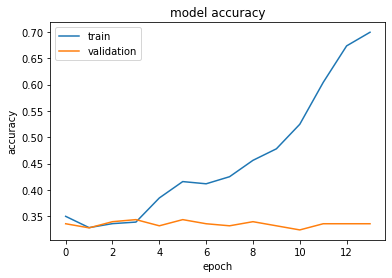

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation Environment


The following function loads the available images for evaluation

In [8]:
test_path = dataset_root_path + test

In [9]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 2


In [42]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 348 images belonging to 3 classes.


## Model Evaluation

In [10]:
#from tensorflow.keras.models import load_model

In [11]:
model = tf.keras.models.load_model(model_file)

In [43]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

2/2 [==============================] - 6s 2s/step - loss: 987241920.0000 - accuracy: 0.3164


In [46]:
predict = model.predict(evaluation_generator)

# print the first 10 predictions
print(predict[:100])

3/3 [==============================] - 7s 2s/step
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [

In [40]:
# Pick one image in test_path and predict it with the model
# Hint: use the function load_img from keras.preprocessing.image

import numpy as np

from tensorflow.keras.preprocessing.image import load_img

img = load_img(test_path + '/german/common_voice_de_17566978.mp3.png', color_mode='grayscale', target_size=(image_height, image_width))

# modify the image to make it fit the model based on the evaluation generator and image data generator
# Hint: use the function img_to_array from keras.preprocessing.image

from tensorflow.keras.preprocessing.image import img_to_array

img = img_to_array(img)
img = img.reshape((1, image_height, image_width, 1))
img = img.astype('float32')
img = img / 255.0

# predict the image with the model
# Hint: use the function predict from keras.models

prediction = model.predict(img)

# print the prediction

print(prediction)

1/1 [==============================] - 0s 53ms/step
[[1. 0. 0.]]


In [33]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 33.2 %
